Описание датасета

GA Sessions
Одна строка = один визит на сайт.
Описание атрибутов:
- session_id — ID визита;
- client_id — ID посетителя;
- visit_date — дата визита;
- visit_time — время визита;
- visit_number — порядковый номер визита клиента;
- utm_source — канал привлечения;
- utm_medium — тип привлечения;
- utm_campaign — рекламная кампания;
- utm_keyword — ключевое слово;
- device_category — тип устройства;
- device_os — ОС устройства;
- device_brand — марка устройства;
- device_model — модель устройства;
- device_screen_resolution — разрешение экрана;
- device_brand — марка устройства;
- device_model — модель устройства;
- device_screen_resolution — разрешение экрана;
- device_browser — браузер;
- geo_country — страна;
- geo_city — город.

GA Hits

- session_id — ID визита;
- hit_date — дата события;
- hit_time — время события;
- hit_number — порядковый номер события в рамках сессии;
- hit_type — тип события;
- hit_referer — источник события;
- hit_page_path — страница события;
- event_category — тип действия;
- event_action — действие;
- event_label — тег действия;
- event_value — значение результата действия.

## 0 - Import

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from scipy.stats import entropy
from sklearn.manifold import TSNE, MDS

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix
from plot_metric.functions import BinaryClassification

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")
from typing import List, NewType
EntropyCategoricalEmbedderObject = NewType('EntropyCategoricalEmbedderObject', object) #creating new type to annotate in our class

## 1 - Load file

In [3]:
df_sessions = pd.read_csv("data/ga_sessions.csv")
df_hits = pd.read_csv("data/ga_hits.csv")

In [4]:
df_sessions.head(5)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [5]:
df_hits.head(5)

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


## 2 - Data Preparation

В задаче нам надо предсказать факт совершения пользователем целевого действия при этом на вход модели будут приходить
фичи  utm_*, device_*, geo_*, поэтому:

1) Необходимо извлечь из таблицы hits факт целевого действия привязанного к session_id.

2) В такой модели не учитываются сессии пользователя, так как фичи visit в модель поступать не будет, поэтому
необходимо привязать факт совершения целевого действия session_id к client_id.
    
3) Предварительная подготовка датасета будет заключаться в сопоставлении сессий и клиентов, извлекем из таблицы hits данные
совершил клиент целевое действие или нет. Так как на вход модели будут поступать только текущие utm_*, device_*, geo_* фичи,
обратиться к таблице hits и посмотреть историю действий клиента мы не сможем, поэтому не имеет смысла создавать из них новые
фичи.

    
4) После удаления дубликатов датасет уменьшится и это облегчит задачу заполнения пропусков. Заполним пропуски
и удалим пустые фичи.

### 2.0 - Preprocessing

In [6]:
# Функция для формирования датасета ключевого действия клиента df_key_action

def create_dataset_key_action(df_sessions, df_hits):

    def target_action(df):
        if df['event_action'] == 'sub_car_claim_click':
            return 1
        elif df['event_action'] == 'sub_car_claim_submit_click':
            return 1
        elif df['event_action'] == 'sub_open_dialog_click':
            return 1
        elif df['event_action'] == 'sub_custom_question_submit_click':
            return 1
        elif df['event_action'] == 'sub_call_number_click':
            return 1
        elif df['event_action'] == 'sub_callback_submit_click':
            return 1
        elif df['event_action'] == 'sub_submit_success':
            return 1
        elif df['event_action'] == 'sub_car_request_submit_click':
            return 1
        else:
            return 0

    df_hits['y'] = df_hits.apply(target_action,
                                 axis=1)  # отмечаем на датасете действия, в которых клиенты совершили target
    df_1 = df_hits[df_hits['y'] == 1].copy()  # отделим действия target от остальных

    # удалим дубликаты сессий target, так как если клиент совершил несколько target, то они приравниваются к одному target

    df_1 = df_1.drop_duplicates(subset=['session_id'])
    df_1 = df_1[['session_id', 'y']]  # оставим только колонку y
    df_sessions = df_sessions.set_index('session_id')
    df_1 = df_1.set_index('session_id')
    df_sessions['y'] = df_1['y']  # target сессии объединяются с df_sessions по индексу
    df_sessions.y = df_sessions.y.astype("str")
    df_sessions = df_sessions.replace({'y': {'nan': '0.0'}})  # заменим nan на 0.0 - клиент не совершил целевое действие
    df_sessions.y = df_sessions.y.astype("float").astype("int")

    # разделим df_sessions датасет на два датасета - сессии где клиент совершил целевое target и не совершил

    df_sessions_1 = df_sessions[df_sessions.y == 1]
    df_sessions_0 = df_sessions[df_sessions.y == 0]

    # удалим сессии в обоих датасетах по client_id, оставим в датасетах только информацию совершил клиент target или нет
    # причем в df_sessions_1 нам не важно какие сессии удалять, а в df_sessions_0 останется последняя сессия target = 0

    df_sessions_1 = df_sessions_1.drop_duplicates(subset=['client_id'])
    df_sessions_0 = df_sessions_0.drop_duplicates(subset=['client_id'], keep='last')
    df_sessions_y = df_sessions_1.append(df_sessions_0)  # объединим датасеты, вверху будут target = 1

    # теперь клиенты target = 1 стоят в начате датафрейма и при удалении дубликатов сессий они сохранятся (keep='first')
    # в df_sessions_y сохранились дубликаты так как в target=0 сохранились client_id да того как они совершили target = 1

    df_sessions_y = df_sessions_y.drop_duplicates(subset=['client_id'], keep='first')

    # удаление колонок, не участвующих в модели по условиям задачи

    df_key_action = df_sessions_y.set_index('client_id')
    df_key_action = df_key_action.drop(
        columns=['visit_date', 'visit_time', 'visit_number'])
    df_key_action = df_key_action.sample(frac=1)  # перемешать

    return df_key_action.copy()

In [7]:
df_key_action = create_dataset_key_action(df_sessions, df_hits)

### 2.1 - Data Cleaning

In [8]:
df_key_action.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1391717 entries, 207632138.16218397 to 558607117.1621851
Data columns (total 14 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   utm_source                1391690 non-null  object
 1   utm_medium                1391717 non-null  object
 2   utm_campaign              1257422 non-null  object
 3   utm_adcontent             1187393 non-null  object
 4   utm_keyword               617910 non-null   object
 5   device_category           1391717 non-null  object
 6   device_os                 628209 non-null   object
 7   device_brand              1139507 non-null  object
 8   device_model              13756 non-null    object
 9   device_screen_resolution  1391717 non-null  object
 10  device_browser            1391717 non-null  object
 11  geo_country               1391717 non-null  object
 12  geo_city                  1391717 non-null  object
 13  y                   

In [9]:
# Функции для определения пропущенных значений в датасете

def fully_populated_values(df):
    print("количество полностью заполненных объектов из всей выборки:", len(df.dropna()))
    print("процент полностью заполненных объектов из всей выборки:", round(len(df.dropna()) / len(df) * 100, 2))
    
def missing_values(df):
    missing_values= ((df.isna().sum() / len(df)) * 100).sort_values(ascending = False)
    print("Процент пропущенных значений для каждого признака: \n")
    print(missing_values)
    missing_values = pd.DataFrame(missing_values)
    list_missing = missing_values[missing_values[0] > 0]
    print("\n")
    print("список всех признаков, в которых имеются пропущенные значения: \n")
    for i in range(len(list_missing)):
        print(list_missing.axes[0][i])

In [10]:
fully_populated_values(df_key_action)

количество полностью заполненных объектов из всей выборки: 12904
процент полностью заполненных объектов из всей выборки: 0.93


In [11]:
missing_values(df_key_action)

Процент пропущенных значений для каждого признака: 

device_model                99.011581
utm_keyword                 55.600887
device_os                   54.860866
device_brand                18.122219
utm_adcontent               14.681433
utm_campaign                 9.649591
utm_source                   0.001940
utm_medium                   0.000000
device_category              0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
y                            0.000000
dtype: float64


список всех признаков, в которых имеются пропущенные значения: 

device_model
utm_keyword
device_os
device_brand
utm_adcontent
utm_campaign
utm_source


Процент полностью заполненных объектов из всей выборки 0.93% поэтому нельзя просто удалить пропущенные строки

В столбце device_model 99% пропущенных значений, так что столбец подлежит удалению

Просмотрим также уникальные значения во всех колонках

In [12]:
df_key_action.utm_keyword.unique()

array([nan, 'puhZPIYqKXeFPaUviSjo', 'jNeZubUpcYKWhGMdPMIS', ...,
       'KkSugNEPSKxihKphlMMa', 'VfhMXDwtKbBKHfyoCvdn',
       'kqlCAoXcilYvojLadiMz'], dtype=object)

In [13]:
df_key_action.device_os.unique()

array([nan, 'iOS', 'Android', 'Windows', 'Macintosh', 'Linux',
       '(not set)', 'BlackBerry', 'Chrome OS', 'Samsung', 'Tizen',
       'Windows Phone', 'Nokia', 'Firefox OS'], dtype=object)

In [14]:
df_key_action.device_brand.unique()

array([nan, 'Samsung', 'ZTE', 'Apple', 'Huawei', 'Vivo', 'Infinix',
       'Xiaomi', 'Realme', 'Motorola', 'Asus', 'Umidigi', 'Nokia',
       '(not set)', 'Google', 'Blackview', 'Lenovo', 'OnePlus', 'Meizu',
       'OPPO', 'Sony', 'BQ', 'LG', 'Ulefone', 'Mozilla', 'itel',
       'Prestigio', 'Tecno', 'Alcatel', 'DOOGEE', 'BlackBerry', 'DEXP',
       'Oukitel', 'Leagoo', 'Coolpad', 'Lava', 'HOMTOM', 'Karbonn', 'HTC',
       'TP-Link', 'Nuu', 'AGM', 'Cubot', 'Philips', 'CAT', 'Neffos',
       'TCL', 'Inoi', 'Sharp', 'Vernee', 'Hisense', 'Haier', 'Highscreen',
       'LeEco', 'POCO', 'Black Fox', 'Fujitsu', 'E&L', 'LeTV', 'BLUBOO',
       'Micromax', 'Mlais', 'Vertex', 'Komu', 'Kata', 'Wileyfox',
       'Vsmart', 'Pantech', 'Fly', 'PPTV', 'China Phone', 'iNew',
       'Evercoss', 'Alldocube', 'Ananda', 'Celkon', 'Mito', 'Teclast',
       'Vestel', 'Billion', 'Tele2', 'T-Mobile', 'Yota Devices', 'Qbex',
       'Acer', 'Guophone', 'Chuwi', 'Honor', 'Dynamic', 'General Mobile',
       'NOA',

In [15]:
df_key_action.utm_adcontent.unique()

array(['JNHcPlZPxEMWDnRiyoBf', nan, 'vCIpmpaGBnIQhyYNkXqp',
       'PkybGvWbaqORmxjNunqZ', 'vIKILzdGQEEbEpgPefxF',
       'yYdBRbPmBMUZHXwqGxNx', 'LLfCasrxQzJIyuldcuWy',
       'xhoenQgDQsgfEPYNPwKO', 'SOkCdPxfUcZUzzOdgGES',
       'WYLajZgbUhGimwBKDZUH', 'qzZQWKnVJAthVIgtLeuA',
       'aYAcKhelKzYpXrRYknSP', 'guyNoEvzgofQvvwExGOq',
       'AdeErYgVTbRcAWtHrMHq', 'tCLxWkPNVjjdHjETjiXL',
       'nNqUcgFgcqQbTVSvgaHr', 'TuyPWsGQruPMpKvRxeBF',
       'UxrnyMlRBSOhOjytXnMG', 'XSkXBCPfnJjvxbfeewtd',
       'qukbsiXCRCiIMciUjStT', 'qhEmhjPXvwgEHdBikgEQ',
       'DZYjhfIUfdqhfuTNUmjn', 'dUuXlWzvmhDSyclWRhNP',
       'NNFDaOyxNbRfjYvClLnM', 'NUkWLMZGFsiVUNEECwyd',
       'eOWmIGTKVDPewucDtZXG', 'LcGIUNPUAmXtQJaDfFBR',
       'nsxJgFVqhmchGMaUusie', 'sYzBROYhjSDbFZCpzGyf',
       'LBoFGHDbSeBOgvTnNlmS', 'XKsYZiUFcdkUXQpoLKyS',
       'ailGqjxuJsYcAqCUFSXX', 'eEkLatVAYTkibdzPIyDi',
       'ESUnXCsdWADovskBLvBO', 'EteMoEECGsaJeMnuvAZD',
       'dlwYatgsQMvLsNApVgcw', 'iyesFzGNBbKbSesPOuQt',
     

In [16]:
df_key_action.utm_campaign.unique()

array(['LTuZkdKfxRGVceoWkVyg', 'bJJuEXRheRIxXEaYIXqM',
       'gecBYcKZCPMcVYdSSzKP', 'LEoPHuyFvzoNfnzGgfcd',
       'LwJZxKuWmvOhPsaCeRjG', nan, 'FTjNLDyTrXaWYgZymFkV',
       'QEejXfOCtOMFLZqIPApp', 'rmVZWYFMcnGputYDEnAW',
       'WlbWUObZWvsimzdFdLYw', 'PXQWdUxeUoXfoKzTBGpY',
       'okTXSMadDkjvntEHzIjp', 'XwZreaZvgptCcKQsSTmK',
       'GWZGdHKPgmZPNPwkJshU', 'bxOTvPtyGSdUrbwoXCPO',
       'SgIUDYUKnyWHVowUOqid', 'zxoiLxhuSIFrCeTLQVWZ',
       'QdLfySaGXolfTBSNVfHn', 'JajANoFxoqXfKRNBUhzx',
       'sbJRYgVfvcnqKJNDDYIr', 'kwdmElMUPDZaLQdgjcsI',
       'sbBROyEMXrSwnajIqxMA', 'IKQsApKuPmZqqmhieEgf',
       'UKNBOHebRIIsQRsjNKay', 'quxdQHtdlpFZfBZSiXFZ',
       'gVwpGdJDpteNmFIatPTG', 'MZTDkjezphpnUHlvfRck',
       'LUlvACDKkkOkiSuiwaBs', 'sTkjcuMUikyInvCPLqNT',
       'IZEXUFLARCUMynmHNBGo', 'nRMQduiDPkgzAtCtRRVx',
       'RoDitORHdzGfGhNCyEMy', 'TmThBvoCcwkCZZUWACYq',
       'WiILFRDQbcHDHNvHzGpX', 'YCKgTzTDywjcWyQudGch',
       'kVOrIKZFrEYGvixPclal', 'nSReTmyFtbSjlPrTKoaX',
     

In [17]:
df_key_action.utm_source.unique()

array(['bByPQxmDaMXgpHeypKSM', 'kjsLglQLzykiRbcDiGcD',
       'ZpYIoDJMcFzVoPFsHGJL', 'MvfHsxITijuriZxsqZqt',
       'fDLlAcSmythWSCVMvqvL', 'hTjLvqNxGggkGnxSCaTm',
       'QxAxdyPLuQMEcrdZWdWb', 'fgymSoTvjKPEgaIJqsiH',
       'SzZERoLMmrEUEhDaYcyN', 'vFcAhRxLfOWKhvxjELkx',
       'jaSOmLICuBzCFqHfBdRg', 'geDcueAOghDzHkGMmdOq',
       'BHcvLfOaCWvWTykYqHVe', 'NwLFDlNWnYxuLZEAZppl',
       'nSReTmyFtbSjlPrTKoaX', 'aXQzDWsJuGXeBXexNHjc',
       'eLzNJHzPelJpEyBwMrKo', 'RmEBuqrriAfAVsLQQmhk',
       'PlbkrSYoHuZBWfYjYnfw', 'gDBGzjFKYabGgSPZvrDH',
       'IZEXUFLARCUMynmHNBGo', 'qVXuCoVQtPxcUkAXiXBa',
       'TxKUcPpthBDPieTGmVhx', 'GpAkIXsclxDGyILfNlrR',
       'ISrKoXQCxqqYvAZICvjs', 'WEXkMlsnJodrzBgKJBpG',
       'GmILPdZyuAVJCPsUBHeN', 'nrKihqcWGIzDsOqljdAv',
       'gVRrcxiDQubJiljoTbGm', 'TTtiRKFZIaQpIWggfCoF',
       'KgicpPxiEQfzPlPwQZJq', 'YlsczTIyBSwTLNtuDkCd',
       'BKeImrJuRDZcHiSSTdzm', 'XiUifkjKLLnomcDRhswp',
       'MYrKypXYDhDVwJMUhCqu', 'eimRuUrNhZLAYcwRrNXu',
       'fb

In [18]:
df_key_action.utm_medium.unique()

array(['referral', 'cpc', 'banner', 'cpm', '(none)', 'stories', 'organic',
       'email', 'push', 'blogger_channel', 'cpv', 'smartbanner', 'tg',
       'smm', 'blogger_stories', 'clicks', 'cpa', 'blogger_header',
       'outlook', 'app', 'post', 'sms', 'ok_smm', 'info_text',
       'yandex_cpc', 'vk_smm', 'landing', '(not set)', 'partner', 'qr',
       'fb_smm', 'static', 'nkp', 'cbaafe', 'web_polka', 'article',
       'catalogue', 'main_polka', 'CPM', 'promo_sber', 'reach',
       'google_cpc', 'users_msk', 'Sbol_catalog', 'landing_interests',
       'link', 'desktop', 'qrcodevideo', 'sber_app', 'linktest',
       'promo_sbol', 'tablet'], dtype=object)

In [19]:
df_key_action.device_category.unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

In [20]:
df_key_action.device_screen_resolution.unique()

array(['1536x864', '320x534', '360x780', ..., '360x948', '424x988',
       '1175x735'], dtype=object)

In [21]:
df_key_action.device_browser.unique()

array(['Edge', 'Chrome', 'Safari', 'Opera', 'Safari (in-app)',
       'YaBrowser', 'NetFront', 'Android Webview', 'Samsung Internet',
       'Firefox', 'Android Browser', 'Puffin', 'MRCHROME',
       'Mozilla Compatible Agent', '[FBAN',
       'Instagram 208.0.0.32.135 Android', 'UC Browser', 'Mozilla',
       'Instagram 209.0.0.21.119 Android',
       'Instagram 212.0.0.38.119 Android', 'Android Runtime', '(not set)',
       'Internet Explorer', 'Android', 'Opera Mini', 'com.vk.vkclient',
       'Konqueror', 'Instagram 158.0.0.30.123 Android',
       'Instagram 213.0.0.19.117', 'Instagram 199.0.0.27.120',
       'Instagram 207.0.0.28.118', 'Instagram 216.1.0.21.137 Android',
       'Instagram 216.0.0.12.135', 'Instagram 202.0.0.37.123 Android',
       'MyApp', 'Instagram 201.0.0.23.111',
       'Instagram 199.1.0.34.119 Android',
       'Instagram 194.0.0.36.172 Android',
       'Instagram 213.0.0.29.120 Android', 'Nokia501',
       'Instagram 202.0.0.23.119', 'Coc Coc', 'Maxthon', 'h

In [22]:
df_key_action.geo_country.unique()

array(['Russia', 'Turkey', 'United States', 'Ireland', 'Israel',
       'Germany', 'Sweden', 'Ukraine', 'Uzbekistan', 'Belarus', 'Armenia',
       'Cyprus', 'Tajikistan', 'United Kingdom', 'Latvia', 'Kazakhstan',
       'Spain', 'Estonia', 'Poland', 'Moldova', 'Singapore', 'Egypt',
       'Morocco', 'Finland', '(not set)', 'Netherlands', 'France',
       'Greece', 'Georgia', 'Azerbaijan', 'Kyrgyzstan', 'Bulgaria',
       'China', 'India', 'Brazil', 'South Korea', 'Saudi Arabia',
       'Turkmenistan', 'Thailand', 'Belgium', 'Maldives', 'Czechia',
       'Italy', 'Japan', 'Seychelles', 'Albania', 'United Arab Emirates',
       'Croatia', 'South Africa', 'Austria', 'Mexico', 'Pakistan',
       'Serbia', 'Sri Lanka', 'Wallis & Futuna', 'Colombia', 'Indonesia',
       'Iran', 'Syria', 'Oman', 'Norway', 'Lithuania', 'Cambodia',
       'Canada', 'Australia', 'Palestine', 'Montenegro', 'Hungary',
       'Iraq', 'Dominican Republic', 'Ethiopia', 'Equatorial Guinea',
       'Afghanistan', 'Swit

In [23]:
df_key_action.geo_city.unique()

array(['Krasnogorsk', 'Saint Petersburg', 'Kurgan', ..., 'Baltimore',
       'Springfield', 'Sandwich'], dtype=object)

После просмотра уникальных значений в колонках видно, что в них присутствуют скрытые пропуски '(none)', '(not set)'.
Создадим функцию, чтобы посчитать количество скрытых пропусков в колонках.
Создадим функцию для заполнения скрытых пропусков.

In [24]:
def calculation_of_hidden_passes(df_pass):
    for column in df_pass.columns:
        len_pass1 = (len(df_pass[df_pass[column] == '(not set)'])/df_pass.shape[0])*100
        len_pass2 = (len(df_pass[df_pass[column] == '(none)'])/df_pass.shape[0])*100
        print(f'Процент скрытых пропусков (not set) в кононке {column} = {len_pass1}')
        print(f'Процент скрытых пропусков (none) в кононке {column} = {len_pass2}')
        
def hidden_gaps(df_gaps):
    list_columns = df_gaps.columns
    for column in list_columns:
        df_gaps.loc[df_gaps[column] == '(not set)', column] = 'other'
        df_gaps.loc[df_gaps[column] == '(none)', column] = 'other'

    return df_gaps.copy()

In [25]:
calculation_of_hidden_passes(df_key_action)

Процент скрытых пропусков (not set) в кононке utm_source = 0.0
Процент скрытых пропусков (none) в кононке utm_source = 0.0
Процент скрытых пропусков (not set) в кононке utm_medium = 0.017388592652098092
Процент скрытых пропусков (none) в кононке utm_medium = 14.599376166275183
Процент скрытых пропусков (not set) в кононке utm_campaign = 0.0
Процент скрытых пропусков (none) в кононке utm_campaign = 0.0
Процент скрытых пропусков (not set) в кононке utm_adcontent = 0.0
Процент скрытых пропусков (none) в кононке utm_adcontent = 0.0
Процент скрытых пропусков (not set) в кононке utm_keyword = 0.0
Процент скрытых пропусков (none) в кононке utm_keyword = 0.0
Процент скрытых пропусков (not set) в кононке device_category = 0.0
Процент скрытых пропусков (none) в кононке device_category = 0.0
Процент скрытых пропусков (not set) в кононке device_os = 0.026082888978147138
Процент скрытых пропусков (none) в кононке device_os = 0.0
Процент скрытых пропусков (not set) в кононке device_brand = 1.0025745

Процент скрытых пропусков в колонках незначительный, поэтому заполним все other.

In [26]:
df_key_action = hidden_gaps(df_key_action)

In [27]:
calculation_of_hidden_passes(df_key_action)

Процент скрытых пропусков (not set) в кононке utm_source = 0.0
Процент скрытых пропусков (none) в кононке utm_source = 0.0
Процент скрытых пропусков (not set) в кононке utm_medium = 0.0
Процент скрытых пропусков (none) в кононке utm_medium = 0.0
Процент скрытых пропусков (not set) в кононке utm_campaign = 0.0
Процент скрытых пропусков (none) в кононке utm_campaign = 0.0
Процент скрытых пропусков (not set) в кононке utm_adcontent = 0.0
Процент скрытых пропусков (none) в кононке utm_adcontent = 0.0
Процент скрытых пропусков (not set) в кононке utm_keyword = 0.0
Процент скрытых пропусков (none) в кононке utm_keyword = 0.0
Процент скрытых пропусков (not set) в кононке device_category = 0.0
Процент скрытых пропусков (none) в кононке device_category = 0.0
Процент скрытых пропусков (not set) в кононке device_os = 0.0
Процент скрытых пропусков (none) в кононке device_os = 0.0
Процент скрытых пропусков (not set) в кононке device_brand = 0.0
Процент скрытых пропусков (none) в кононке device_bran

В модели будут только категориальные признаки, так как нельзя ответить на вопрос какая категория лучше или хуже (больше или <)
Из таких признаков нельзя создать численные количественные фичи. Поэтому чем больше комбинаций категорий будет в модели, тем
лучше, поэтому нельзя удалять строки с пропусками. Если их удалить от датасета ничего не останется.

    Заполним пропуски следующим образом:

    1) Фичи с количеством пропусков больше 80% подлежат удалению (device_model)
    
    2) Фичи с количеством пропусков < 20% подлежат заполнению модой
    
    3) Фичи с количеством пропусков > 20% но меньше 80% подлежат заполению other, так как заполнение модой сильно исказит df

In [28]:
def fill_missing_values(df_old):
    missing_values = ((df_old.isna().sum() / len(df_old)) * 100).sort_values(ascending=False)
    missing_values = pd.DataFrame(missing_values)  # датафрейм процент пропущенных значений для каждого признака
    df_missing_drop = missing_values[missing_values[0] > 80]  # датафрейм признаков которые подлежат удалению
    df_missing_mode = missing_values[
        (missing_values[0] < 20) & (
        (missing_values[0] > 0))]  # датафрейм признаков которые подлежат заполнению модой
    df_missing_other = missing_values[
        (missing_values[0] > 20) & ((missing_values[0] < 80))]  # датафрейм признаков кот.
    # подлежат заполению other
    missing_drop = df_missing_drop.index.to_list()
    missing_mode = df_missing_mode.index.to_list()
    missing_other = df_missing_other.index.to_list()

    # списки колонок с пропущенными значениями
    df_old = df_old.drop(columns=missing_drop)

    for column in missing_mode:
        df_old[column] = df_old[column].fillna(df_old[column].mode()[0])

    for column in missing_other:
        df_old[column] = df_old[column].fillna('other')

    return df_old.copy()

In [29]:
df_key_action = fill_missing_values(df_key_action)

In [30]:
fully_populated_values(df_key_action)

количество полностью заполненных объектов из всей выборки: 1391717
процент полностью заполненных объектов из всей выборки: 100.0


In [31]:
missing_values(df_key_action)

Процент пропущенных значений для каждого признака: 

utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
utm_adcontent               0.0
utm_keyword                 0.0
device_category             0.0
device_os                   0.0
device_brand                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
y                           0.0
dtype: float64


список всех признаков, в которых имеются пропущенные значения: 



### 2.2 - Format Data

Для последующего преобразования категориальных признаков необходим Dtype = object, поэтому пропускаем этот этап

### 2.3 - Data outliers

В датасете присутствуют только категориальные признаки, а выбросы в данных могут быть только у количественных признаков. Пропускаем этот этап

## 3 - Feature engineering

### 3.1 - Преобразование категориальных переменных

In [71]:
df = df_key_action.copy()
df.nunique()

utm_source                   263
utm_medium                    51
utm_campaign                 388
utm_adcontent                271
utm_keyword                 1167
device_category                3
device_os                     13
device_brand                 205
device_screen_resolution    4964
device_browser                56
geo_country                  164
geo_city                    2477
y                              2
dtype: int64

In [72]:
df.device_browser.unique()

array(['Edge', 'Chrome', 'Safari', 'Opera', 'Safari (in-app)',
       'YaBrowser', 'NetFront', 'Android Webview', 'Samsung Internet',
       'Firefox', 'Android Browser', 'Puffin', 'MRCHROME',
       'Mozilla Compatible Agent', '[FBAN',
       'Instagram 208.0.0.32.135 Android', 'UC Browser', 'Mozilla',
       'Instagram 209.0.0.21.119 Android',
       'Instagram 212.0.0.38.119 Android', 'Android Runtime', 'other',
       'Internet Explorer', 'Android', 'Opera Mini', 'com.vk.vkclient',
       'Konqueror', 'Instagram 158.0.0.30.123 Android',
       'Instagram 213.0.0.19.117', 'Instagram 199.0.0.27.120',
       'Instagram 207.0.0.28.118', 'Instagram 216.1.0.21.137 Android',
       'Instagram 216.0.0.12.135', 'Instagram 202.0.0.37.123 Android',
       'MyApp', 'Instagram 201.0.0.23.111',
       'Instagram 199.1.0.34.119 Android',
       'Instagram 194.0.0.36.172 Android',
       'Instagram 213.0.0.29.120 Android', 'Nokia501',
       'Instagram 202.0.0.23.119', 'Coc Coc', 'Maxthon', 'hello

В колонке device_browser имеются не корректные данные браузера. Преобразуем их в нормальный формат.
Скорее всего Instagram 216.1.0.21.137 Android это приложение инстаграмм. Оставим с помощью функции только первые символы

In [73]:
def normal_str(str_list):
    if str_list[0:9] == 'Instagram':
        str_list = 'Instagram'
    if str_list[0:7] == 'Threads':
        str_list = 'Threads'
    if str_list[0:5] == '[FBAN':
        str_list = 'Facebook'
    if str_list[0:10] == 'helloworld':
        str_list = 'other'
    return str_list

In [74]:
df.device_browser = df.device_browser.apply(normal_str)

In [75]:
df.device_browser.unique()

array(['Edge', 'Chrome', 'Safari', 'Opera', 'Safari (in-app)',
       'YaBrowser', 'NetFront', 'Android Webview', 'Samsung Internet',
       'Firefox', 'Android Browser', 'Puffin', 'MRCHROME',
       'Mozilla Compatible Agent', 'Facebook', 'Instagram', 'UC Browser',
       'Mozilla', 'Android Runtime', 'other', 'Internet Explorer',
       'Android', 'Opera Mini', 'com.vk.vkclient', 'Konqueror', 'MyApp',
       'Nokia501', 'Coc Coc', 'Maxthon', 'Amazon Silk', 'SeaMonkey',
       'Threads', 'NokiaX2-02', 'Iron', 'MT6735_TD',
       'com.zhiliaoapp.musically'], dtype=object)

Количество уникальных значений в колонке device_screen_resolution = 4964.
Датасет после OneHotEncoder будет просто огромный в ширину. Разделим этот признак на несколько категорий

In [76]:
df.loc[df['device_screen_resolution'] == 'other', 'device_screen_resolution'] = '0x0'

In [77]:
def pixels(screen_resolution):
    screen_list = screen_resolution.split('x')
    pixels = int(screen_list[0]) * int(screen_list[1])

    return pixels

In [78]:
df.device_screen_resolution = df.device_screen_resolution.apply(pixels)

In [79]:
def distribution(df):
    plt.figure(figsize=(8, 5))
    plt.hist(df, bins=50, color="indigo")
    plt.xlabel('Значение величины')
    plt.ylabel('Частота')
    plt.title('Распределение по выборке');

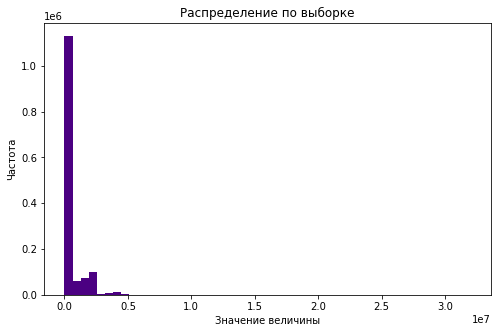

In [80]:
distribution(df.device_screen_resolution)

In [81]:
df.device_screen_resolution.value_counts(bins=100)

(-32000.001, 320000.0]      606460
(320000.0, 640000.0]        523340
(1920000.0, 2240000.0]       92214
(1280000.0, 1600000.0]       63631
(960000.0, 1280000.0]        35554
                             ...  
(18880000.0, 19200000.0]         0
(19520000.0, 19840000.0]         0
(19840000.0, 20160000.0]         0
(20160000.0, 20480000.0]         0
(16000000.0, 16320000.0]         0
Name: device_screen_resolution, Length: 100, dtype: int64

Сгруппируем категории так, чтобы было примерно равномерное распределение по категориям

In [82]:
len(df[df.device_screen_resolution < 300000])

473722

In [83]:
len(df[(df.device_screen_resolution >= 300000 ) & (df.device_screen_resolution <= 375000)])

552227

In [84]:
len(df[df.device_screen_resolution > 375000])

365768

In [85]:
def pixels_range(pixel):
    if pixel == 0:
        resolution = 'other'
    elif (pixel > 0) & (pixel < 300000):
        resolution = 'low'
    elif pixel > 375000:
        resolution = 'high'
    else:
        resolution = 'medium'

    return resolution

In [86]:
df.device_screen_resolution = df.device_screen_resolution.apply(pixels_range)

In [87]:
df.nunique()

utm_source                   263
utm_medium                    51
utm_campaign                 388
utm_adcontent                271
utm_keyword                 1167
device_category                3
device_os                     13
device_brand                 205
device_screen_resolution       4
device_browser                36
geo_country                  164
geo_city                    2477
y                              2
dtype: int64

In [88]:
df.device_screen_resolution.value_counts()

medium    552227
low       473703
high      365768
other         19
Name: device_screen_resolution, dtype: int64

In [89]:
df.nunique()

utm_source                   263
utm_medium                    51
utm_campaign                 388
utm_adcontent                271
utm_keyword                 1167
device_category                3
device_os                     13
device_brand                 205
device_screen_resolution       4
device_browser                36
geo_country                  164
geo_city                    2477
y                              2
dtype: int64

geo_city - преобразовать никак невозможно, потому как снижение количества уникальных значений сильно повлияет на модель
и этот признак станет бесполезным, так как сберавтоподписка работает в разных регионах этот параметр необходимо учитывать.
utm_keyword - ключевое слово тоже невозможно никак преобразовать
То есть дальнейшие преобразования категориальных признаков невозможны.

посчитаем размерность датасета после преобразования ohe

In [90]:
number_of_cat = 0
for col in df.columns:
    number_of_cat += df[col].unique().shape[0]
number_of_cat

5044

Размерность датасета после преобразования по прежнему огромная. Стандартными методами преобразовать датасет для моделирования
затруднительно. Модель может работать только с числовыми признаками.

## 4 - Modelling

### 4.1 - Кодирование категориальных признаков для этапа моделирования

In [15]:
df_model = pd.read_csv('data/df.csv')
df_model

,client_id,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,y
0,207632138.162184,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,other,desktop,other,Apple,high,Edge,Russia,Krasnogorsk,0
1,874891208.163137,kjsLglQLzykiRbcDiGcD,cpc,bJJuEXRheRIxXEaYIXqM,JNHcPlZPxEMWDnRiyoBf,other,mobile,other,Samsung,low,Chrome,Russia,Saint Petersburg,0
2,1930738110.163113,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,other,mobile,other,ZTE,low,Chrome,Russia,Kurgan,0
3,957117224.163813,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,medium,Safari,Russia,Moscow,0
4,758400556.163319,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,other,mobile,other,Apple,high,Safari,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391712,1454609777.163706,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Xiaomi,low,Chrome,Russia,Moscow,0
1391713,2083824555.163747,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,low,Safari,Russia,Surgut,0
1391714,1809262921.163431,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,other,mobile,other,Apple,medium,Safari,Russia,Moscow,0
1391715,538494300.163927,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,low,Chrome,Russia,Novosibirsk,0


Применим нестандартное кодирование (вероятностный подход) для уменьшения размерности df и экономии памяти
Источник https://github.com/art-glazunov/Non-standard-categorical-encodings/blob/main/group_counts_and_entropy.ipynb

In [16]:
class EntropyCategoricalEmbedder:
    """Unsupervised categorical embedder based on group counts and entropy calculation

    fit - get dictionary for the transformation of categorical objects into embeddings 
    transform - map the dictionary onto your categorical dataset to get the embeddings
    """

    def __init__(self):
        self.substitute_dict = {} #resulting dictionary to transform the objects into embs

    def __repr__(self):
        return self.__class__.__name__ + "()"
    
    @staticmethod
    def cat_prep(data: pd.DataFrame) -> pd.DataFrame:
        """change category names for simplification

        format -> category-name_category-name
        """

        data_new = data.copy()
        for col in tqdm(data.columns):
            data_new[col] = data[col].apply(lambda x: col + '_' + str(x))
        return data_new
    
    def fit(self, df_train: pd.DataFrame, verbose: bool = True) -> EntropyCategoricalEmbedderObject: # we created this custom type earlier
        """Create dictionary to map on the dataset

        !!!Works only with categorical datasets!!!
        dataset - pandas DataFrame with only categorical columns in str format (after cat_prep) 
        (each row is our object to get an embedding for)
        """
        
        feature_list = list(df_train.columns)
        df = df_train.copy()
        df['id'] = df.index
        for group_key in tqdm(feature_list):    
            passive_keys = feature_list[:]
            passive_keys.remove(group_key)

            category_embedding_mapping = {}
            for passive_key in passive_keys:
                if verbose:
                    print('--- groupby: group_key - ', group_key, '### passive_key - ', passive_key, '---')                
                group = df.groupby([group_key, passive_key])['id'].count()
                group = group.unstack().fillna(0)
                entropy_values = group.apply(entropy, axis=1)
                for cat, entropy_value in entropy_values.to_dict().items():
                    if cat in category_embedding_mapping:
                        category_embedding_mapping[cat].extend([entropy_value]) 
                    else:
                        category_embedding_mapping[cat] = [entropy_value]
                
            self.substitute_dict[group_key] = category_embedding_mapping  
        return self

    def transform(self, dataset: pd.DataFrame, 
                  fill_unknown_cat_value: int = 0,
                  verbose: bool = False) -> List[list]:
        """Get embedding for each categorical row of the dataset

        !!!Works only with categorical datasets!!!
        dataset - pandas DataFrame with only categorical columns in str format (after cat_prep) 
        (each row is our object to get an embedding for)
        fill_unknown_cat_value - the value to fill embedding vector for unknown categories
        """

        dataset = dataset.copy()
        feature_list = list(dataset.columns)        
        emb_size = len(feature_list) - 1
        if verbose:
            print("Mapping vectors to categories...")
        for f in tqdm(feature_list):
            dataset[f] = dataset[f].map(self.substitute_dict[f])              
            dataset[f] = dataset[f].fillna('empty')
            dataset[f] = dataset[f].apply(lambda x: [fill_unknown_cat_value] * emb_size if x == 'empty' else x)
        
        embeddings_list = []
        if verbose:
            print("Creating an embedding for each row...")
        for row in tqdm(dataset[feature_list].itertuples()):
            embeddings_list.append(list(itertools.chain(*row[1:])))

        return embeddings_list

In [17]:
df_model = df_model.drop(['client_id'], axis=1)
x = df_model.drop(['y'], axis=1)
y = df_model['y']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [18]:
df_train = X_train.copy()
df_train = EntropyCategoricalEmbedder.cat_prep(df_train)
df_train.head()

  0%|          | 0/12 [00:00<?, ?it/s]

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
82936,utm_source_fDLlAcSmythWSCVMvqvL,utm_medium_other,utm_campaign_LTuZkdKfxRGVceoWkVyg,utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_other,device_category_mobile,device_os_other,device_brand_Apple,device_screen_resolution_medium,device_browser_Safari,geo_country_Russia,geo_city_Nizhny Novgorod
575196,utm_source_ZpYIoDJMcFzVoPFsHGJL,utm_medium_smartbanner,utm_campaign_jqlUOdZBNZYfInQVcZlS,utm_adcontent_SAVVWaMghGnnvPOqMOIt,utm_keyword_puhZPIYqKXeFPaUviSjo,device_category_mobile,device_os_Android,device_brand_Samsung,device_screen_resolution_high,device_browser_Chrome,geo_country_Russia,geo_city_Saint Petersburg
1362073,utm_source_MvfHsxITijuriZxsqZqt,utm_medium_cpm,utm_campaign_FTjNLDyTrXaWYgZymFkV,utm_adcontent_xhoenQgDQsgfEPYNPwKO,utm_keyword_other,device_category_mobile,device_os_other,device_brand_Samsung,device_screen_resolution_low,device_browser_Samsung Internet,geo_country_Russia,geo_city_Moscow
373883,utm_source_MvfHsxITijuriZxsqZqt,utm_medium_cpm,utm_campaign_FTjNLDyTrXaWYgZymFkV,utm_adcontent_PkybGvWbaqORmxjNunqZ,utm_keyword_other,device_category_mobile,device_os_other,device_brand_other,device_screen_resolution_low,device_browser_YaBrowser,geo_country_Russia,geo_city_Saint Petersburg
1216981,utm_source_MvfHsxITijuriZxsqZqt,utm_medium_cpm,utm_campaign_FTjNLDyTrXaWYgZymFkV,utm_adcontent_dUuXlWzvmhDSyclWRhNP,utm_keyword_other,device_category_mobile,device_os_other,device_brand_Samsung,device_screen_resolution_low,device_browser_YaBrowser,geo_country_Russia,geo_city_Moscow


In [19]:
df_test = X_test.copy()
df_test = EntropyCategoricalEmbedder.cat_prep(df_test)
df_test.head()

  0%|          | 0/12 [00:00<?, ?it/s]

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
1135697,utm_source_geDcueAOghDzHkGMmdOq,utm_medium_cpm,utm_campaign_FTjNLDyTrXaWYgZymFkV,utm_adcontent_WYLajZgbUhGimwBKDZUH,utm_keyword_other,device_category_mobile,device_os_other,device_brand_Xiaomi,device_screen_resolution_medium,device_browser_Android Webview,geo_country_Russia,geo_city_Kaliningrad
145221,utm_source_kjsLglQLzykiRbcDiGcD,utm_medium_cpc,utm_campaign_LTuZkdKfxRGVceoWkVyg,utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_other,device_category_mobile,device_os_other,device_brand_Xiaomi,device_screen_resolution_medium,device_browser_Chrome,geo_country_Russia,geo_city_Moscow
341526,utm_source_hTjLvqNxGggkGnxSCaTm,utm_medium_stories,utm_campaign_QEejXfOCtOMFLZqIPApp,utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_other,device_category_mobile,device_os_other,device_brand_OnePlus,device_screen_resolution_medium,device_browser_Android Webview,geo_country_Ukraine,geo_city_Kyiv
1381201,utm_source_fDLlAcSmythWSCVMvqvL,utm_medium_other,utm_campaign_LTuZkdKfxRGVceoWkVyg,utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_other,device_category_desktop,device_os_other,device_brand_Apple,device_screen_resolution_high,device_browser_Edge,geo_country_Russia,geo_city_Saint Petersburg
902478,utm_source_fDLlAcSmythWSCVMvqvL,utm_medium_other,utm_campaign_LTuZkdKfxRGVceoWkVyg,utm_adcontent_JNHcPlZPxEMWDnRiyoBf,utm_keyword_other,device_category_desktop,device_os_other,device_brand_Apple,device_screen_resolution_high,device_browser_YaBrowser,geo_country_Russia,geo_city_Saint Petersburg


In [20]:
embedder = EntropyCategoricalEmbedder()
embedder

EntropyCategoricalEmbedder()

In [21]:
%%time
embedder.fit(df_train, verbose=False)

  0%|          | 0/12 [00:00<?, ?it/s]

Wall time: 36.4 s


EntropyCategoricalEmbedder()

In [22]:
%%time
train_feat = embedder.transform(df_train)

  0%|          | 0/12 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Wall time: 16.5 s


In [23]:
%%time
test_feat = embedder.transform(df_test)

  0%|          | 0/12 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Wall time: 8.24 s


In [24]:
np.array(test_feat)

array([[0.        , 0.01776948, 0.02339191, ..., 1.07927553, 1.20311963,
        0.        ],
       [0.35368936, 2.55419398, 0.56366517, ..., 1.08105332, 1.4150564 ,
        0.        ],
       [0.56516568, 0.76614635, 0.        , ..., 1.06600711, 1.59104835,
        0.        ],
       ...,
       [0.26241589, 1.45912113, 0.70171256, ..., 1.00469607, 0.92677599,
        0.        ],
       [0.57290121, 3.10725215, 0.03885377, ..., 1.02109376, 1.13800016,
        0.        ],
       [0.25891308, 0.10271922, 0.90408414, ..., 1.06038674, 1.32912096,
        0.        ]])

In [25]:
np.array(test_feat).shape

(417516, 132)

размерность данных уменьшилось в ширину до 132 признаков

### 4.2 - Выбор модели машинного обучения

логисчитеская регрессия

In [26]:
%%time
lr_pipe = Pipeline([('scaler', StandardScaler()),
                      ('classifier', LogisticRegression())])
lr_pipe.fit(train_feat, y_train)

Wall time: 1min 6s


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

In [27]:
probs = lr_pipe.predict_proba(test_feat)
score_lr_scaled = roc_auc_score(y_test, probs[:, 1])
print(score_lr_scaled)

0.689506742237247


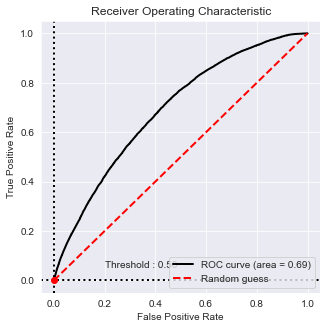

In [28]:
bc = BinaryClassification(y_test, probs[:, 1], labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

ROC-AUC > 0.65, задача выполнена. Обучим другие модели классификации

случайный лес

In [29]:
%%time
tree = RandomForestClassifier()
tr_pipe = Pipeline([('scaler', StandardScaler()),
                      ('classifier', tree)])
tr_pipe.fit(train_feat, y_train)
probs_tr = tr_pipe.predict_proba(test_feat)
score_tr_scaled = roc_auc_score(y_test, probs_tr[:, 1])
print(score_tr_scaled)

0.6489671697346944
Wall time: 15min 19s


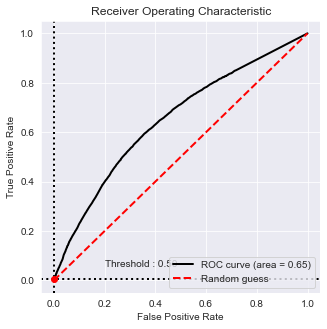

In [30]:
bc_tr = BinaryClassification(y_test, probs_tr[:, 1], labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc_tr.plot_roc_curve()
plt.show()

Линейный дискриминантный анализ

In [31]:
%%time
nb_pipe = Pipeline([('scaler', StandardScaler()),
                      ('classifier', LinearDiscriminantAnalysis())])
nb_pipe.fit(train_feat, y_train)
probs_nb = nb_pipe.predict_proba(test_feat)
score_nb_scaled = roc_auc_score(y_test, probs_nb[:, 1])
print(score_nb_scaled)

0.6866815584425026
Wall time: 1min 47s


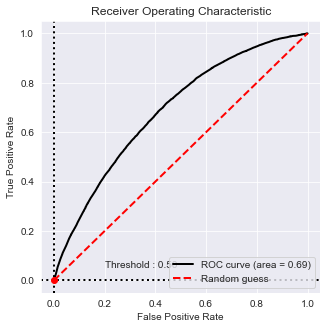

In [33]:
bc_nb = BinaryClassification(y_test, probs_nb[:, 1], labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc_nb.plot_roc_curve()
plt.show()

Многоуровневый классификатор Perceptron

In [34]:
%%time
perp_pipe = Pipeline([('scaler', StandardScaler()),
                      ('classifier', MLPClassifier())])
perp_pipe.fit(train_feat, y_train)
probs_perp = perp_pipe.predict_proba(test_feat)
score_perp_scaled = roc_auc_score(y_test, probs_perp[:, 1])
print(score_perp_scaled)

0.7016702228366847
Wall time: 11min 19s


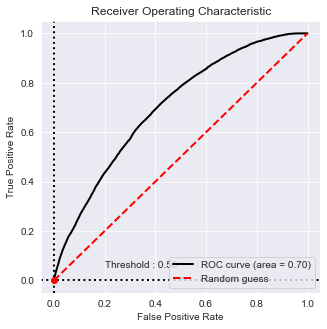

In [35]:
bc_perp = BinaryClassification(y_test, probs_perp[:, 1], labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc_perp.plot_roc_curve()
plt.show()

Персептрон лучше всех показал себя. ROC-AUC = 0.70.

In [36]:
predict = perp_pipe.predict(test_feat)
accuracy = accuracy_score(y_test, predict)
print(accuracy)

0.9687916151716341


In [37]:
confusion_matrix(y_test, predict)

array([[404483,      0],
       [ 13030,      3]], dtype=int64)

В таком виде с стандартным порогом персептрон практически не предсказывает класс = 1, но и ошибок в предсказании класса 0 нет

In [38]:
def qwerty(q, k):
    for i in range(0, len(q)):
        if q[i] < k:
            q[i] = 0
        else:
            q[i] = 1
    return q

In [68]:
q = probs_perp[:, 1].copy()
qwerty(q, 0.009)
confusion_matrix(y_test, q)

array([[ 63233, 341250],
       [   282,  12751]], dtype=int64)

Так как в задаче не сказано для чего именно нам нужно предсказание целевого действия, мы не можем определить, какой порог нам
необходим. Если нам нужно предсказать как можно больше клиентов, которые выполнят целевое действие, то порог должен быть малым
и будет большая ошибка (только 5-10% предсказаний будет верным). Если нам необходимо предсказать как можно точнее, то порог
должен быть большим и количество True postive будем малым